# Experimental Validation of Condensate-Mediated Enhancer-Promoter Contacts

This notebook tests predictions from the Goh et al. (2025) model against experimental Hi-C/Micro-C and RNA-seq data from mouse embryonic stem cells (mESCs).

## Scientific Question

The Goh et al. model predicts that **RNA gradients guide transcriptional condensates toward gene promoters**, which should increase enhancer-promoter contact frequencies. Specifically:

1. **Higher transcription -> steeper RNA gradient -> stronger condensate attraction -> more E-P contacts**
2. **This effect should be distance-dependent**: strongest at intermediate genomic distances (50-200 kb)
3. **Super-enhancers** (where condensates form) should show stronger effects than typical enhancers

## Data Sources

We use publicly available data from Hsieh et al. (2022) Nature Genetics:
- **Micro-C**: High-resolution chromatin contact maps (GEO: GSE130275, GSE186454)
- **RNA-seq**: Gene expression data from the same mESC line
- **ChIP-seq**: H3K27ac, MED1, BRD4 for identifying enhancers and super-enhancers

## Outline

1. Download and preprocess data
2. Build enhancer-promoter pair catalog
3. Extract contact frequencies and expression values
4. Test prediction: correlation between expression and contacts
5. Test prediction: distance-dependence of the effect
6. Compare super-enhancers vs typical enhancers

In [10]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Plotting settings
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
sns.set_style('whitegrid')

# Data directories
DATA_DIR = Path('../data/experimental')
DATA_DIR.mkdir(parents=True, exist_ok=True)

print("Imports successful!")
print(f"Data directory: {DATA_DIR.resolve()}")

Imports successful!
Data directory: /Users/rishikumar/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Group Project/condensate_project/data/experimental


---
## Part 1: Data Download and Setup

We need three types of data:
1. **Micro-C contact matrix** (`.mcool` or `.hic` format)
2. **Gene expression** (RNA-seq, processed TPM/FPKM values)
3. **Enhancer annotations** (from H3K27ac ChIP-seq peaks)

In [11]:
# Data file paths (update these after downloading)
MICROC_FILE = DATA_DIR / 'mESC_MicroC.mcool'
RNASEQ_FILE = DATA_DIR / 'mESC_expression.tsv'
ENHANCER_FILE = DATA_DIR / 'mESC_H3K27ac_peaks.bed'
GENE_ANNOTATION = DATA_DIR / 'mm39_genes_tss.bed'
SUPER_ENHANCER_FILE = DATA_DIR / 'mESC_super_enhancers.bed'

# Check which files exist
print("Data file status:")
for name, path in [('Micro-C', MICROC_FILE), ('RNA-seq', RNASEQ_FILE), 
                   ('Enhancers', ENHANCER_FILE), ('Genes', GENE_ANNOTATION),
                   ('Super-enhancers', SUPER_ENHANCER_FILE)]:
    status = 'Found' if path.exists() else 'Missing'
    print(f"  {name}: {status} ({path.name})")

Data file status:
  Micro-C: Found (mESC_MicroC.mcool)
  RNA-seq: Found (mESC_expression.tsv)
  Enhancers: Found (mESC_H3K27ac_peaks.bed)
  Genes: Found (mm39_genes_tss.bed)
  Super-enhancers: Missing (mESC_super_enhancers.bed)


In [4]:
# Instructions for downloading data
download_instructions = """
=== DATA DOWNLOAD INSTRUCTIONS ===

1. MICRO-C DATA (from 4DN or GEO):
   - 4DN Portal: https://data.4dnucleome.org/
   - Search for "mESC Micro-C"
   - Download .mcool file
   - Save as: data/experimental/mESC_MicroC.mcool

2. RNA-SEQ DATA:
   - ENCODE: https://www.encodeproject.org/
   - Search: "RNA-seq mouse embryonic stem cell"
   - Download gene quantifications (TPM or FPKM)
   - Save as: data/experimental/mESC_expression.tsv

3. ENHANCER PEAKS (H3K27ac ChIP-seq):
   - ENCODE: Search "H3K27ac ChIP-seq mESC"
   - Download narrowPeak or bed file
   - Save as: data/experimental/mESC_H3K27ac_peaks.bed

4. GENE ANNOTATIONS:
   - GENCODE: https://www.gencodegenes.org/mouse/
   - Download GTF, extract TSS positions
   - Save as: data/experimental/mm10_genes.bed

5. SUPER-ENHANCER CALLS (optional):
   - dbSUPER: http://asntech.org/dbsuper/
   - Save as: data/experimental/mESC_super_enhancers.bed
"""
print(download_instructions)


=== DATA DOWNLOAD INSTRUCTIONS ===

1. MICRO-C DATA (from 4DN or GEO):
   - 4DN Portal: https://data.4dnucleome.org/
   - Search for "mESC Micro-C"
   - Download .mcool file
   - Save as: data/experimental/mESC_MicroC.mcool

2. RNA-SEQ DATA:
   - ENCODE: https://www.encodeproject.org/
   - Search: "RNA-seq mouse embryonic stem cell"
   - Download gene quantifications (TPM or FPKM)
   - Save as: data/experimental/mESC_expression.tsv

3. ENHANCER PEAKS (H3K27ac ChIP-seq):
   - ENCODE: Search "H3K27ac ChIP-seq mESC"
   - Download narrowPeak or bed file
   - Save as: data/experimental/mESC_H3K27ac_peaks.bed

4. GENE ANNOTATIONS:
   - GENCODE: https://www.gencodegenes.org/mouse/
   - Download GTF, extract TSS positions
   - Save as: data/experimental/mm10_genes.bed

5. SUPER-ENHANCER CALLS (optional):
   - dbSUPER: http://asntech.org/dbsuper/
   - Save as: data/experimental/mESC_super_enhancers.bed



---
## Part 2: Load and Process Data

In [12]:
def load_gene_expression(filepath):
    """Load gene expression data from TSV file."""
    df = pd.read_csv(filepath, sep='\t')
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    if 'tpm' in df.columns:
        df['log2_tpm'] = np.log2(df['tpm'] + 1)
    elif 'fpkm' in df.columns:
        df['log2_tpm'] = np.log2(df['fpkm'] + 1)
        df['tpm'] = df['fpkm']
    print(f"Loaded expression for {len(df)} genes")
    return df

def load_bed_file(filepath, names=None):
    """Load a BED file into a DataFrame."""
    if names is None:
        names = ['chrom', 'start', 'end', 'name', 'score', 'strand']
    with open(filepath) as f:
        n_cols = len(f.readline().strip().split('\t'))
    names = names[:n_cols]
    df = pd.read_csv(filepath, sep='\t', names=names, comment='#')
    print(f"Loaded {len(df)} regions from {filepath.name}")
    return df

def load_microc_matrix(filepath, resolution=5000):
    """Load Micro-C contact matrix from .mcool file."""
    try:
        import cooler
        clr = cooler.Cooler(f"{filepath}::resolutions/{resolution}")
        print(f"Loaded Micro-C at {resolution/1000:.0f}kb resolution")
        return clr
    except ImportError:
        print("Please install cooler: pip install cooler")
        return None

In [14]:
# Load data (uncomment after downloading)
expression_df = load_gene_expression(RNASEQ_FILE)
enhancers_df = load_bed_file(ENHANCER_FILE)
genes_df = load_bed_file(GENE_ANNOTATION)
# super_enhancers_df = load_bed_file(SUPER_ENHANCER_FILE)
clr = load_microc_matrix(MICROC_FILE, resolution=5000)

print("[Data loading commented out - uncomment after downloading]")

Loaded expression for 81881 genes
Loaded 37268 regions from mESC_H3K27ac_peaks.bed
Loaded 21740 regions from mm39_genes_tss.bed
Loaded Micro-C at 5kb resolution
[Data loading commented out - uncomment after downloading]


---
## Part 3: Build Enhancer-Promoter Pair Catalog

In [15]:
def get_promoter_position(gene_row):
    """Get TSS position for a gene."""
    if gene_row.get('strand', '+') == '+':
        return gene_row['start']
    return gene_row['end']

def build_ep_pairs(genes_df, enhancers_df, expression_df,
                   min_distance=5000, max_distance=500000):
    """Build catalog of enhancer-promoter pairs."""
    ep_pairs = []
    expr_lookup = expression_df.set_index('gene_name')['tpm'].to_dict()
    
    for _, gene in genes_df.iterrows():
        gene_name = gene['name']
        gene_chrom = gene['chrom']
        promoter_pos = get_promoter_position(gene)
        expression = expr_lookup.get(gene_name, np.nan)
        if np.isnan(expression):
            continue
        
        chrom_enhancers = enhancers_df[enhancers_df['chrom'] == gene_chrom]
        for _, enh in chrom_enhancers.iterrows():
            enh_center = (enh['start'] + enh['end']) // 2
            distance = abs(enh_center - promoter_pos)
            if min_distance <= distance <= max_distance:
                ep_pairs.append({
                    'gene_name': gene_name, 'gene_chrom': gene_chrom,
                    'promoter_pos': promoter_pos, 'enhancer_center': enh_center,
                    'distance': distance, 'expression': expression,
                    'log2_expression': np.log2(expression + 1)
                })
    
    ep_df = pd.DataFrame(ep_pairs)
    print(f"Built {len(ep_df)} E-P pairs, {ep_df['gene_name'].nunique()} unique genes")
    return ep_df

def annotate_super_enhancers(ep_df, super_enhancers_df):
    """Add super-enhancer flag to E-P pairs."""
    ep_df = ep_df.copy()
    ep_df['is_super_enhancer'] = False
    for idx, row in ep_df.iterrows():
        se_chrom = super_enhancers_df[super_enhancers_df['chrom'] == row['gene_chrom']]
        for _, se in se_chrom.iterrows():
            if se['start'] <= row['enhancer_center'] <= se['end']:
                ep_df.at[idx, 'is_super_enhancer'] = True
                break
    print(f"Annotated {ep_df['is_super_enhancer'].sum()} super-enhancer pairs")
    return ep_df

---
## Part 4: Extract Contact Frequencies from Micro-C

In [16]:
def get_contact_frequency(clr, chrom, pos1, pos2, window=5000):
    """Extract contact frequency between two positions."""
    try:
        import cooler
        resolution = clr.binsize
        bin1 = pos1 // resolution
        bin2 = pos2 // resolution
        matrix = clr.matrix(balance=True).fetch(chrom)
        observed = matrix[bin1, bin2] if not np.isnan(matrix[bin1, bin2]) else 0
        distance = abs(pos2 - pos1)
        expected = 1.0 / (distance // resolution) if distance > 0 else 1.0
        obs_exp = observed / expected if expected > 0 else np.nan
        return observed, expected, obs_exp
    except:
        return np.nan, np.nan, np.nan

def compute_contact_frequencies_for_pairs(ep_df, clr, window=5000):
    """Compute contact frequencies for all E-P pairs."""
    results = [get_contact_frequency(clr, row['gene_chrom'], row['promoter_pos'],
                                      row['enhancer_center'], window)
               for _, row in ep_df.iterrows()]
    ep_df['observed_contacts'] = [r[0] for r in results]
    ep_df['expected_contacts'] = [r[1] for r in results]
    ep_df['obs_exp_ratio'] = [r[2] for r in results]
    ep_df['log2_obs_exp'] = np.log2(ep_df['obs_exp_ratio'])
    print(f"Valid pairs: {ep_df['obs_exp_ratio'].notna().sum()} / {len(ep_df)}")
    return ep_df

---
## Part 5: Test Goh et al. Predictions

In [17]:
def test_expression_contact_correlation(ep_df, min_expression=1.0):
    """Test correlation between expression and E-P contacts."""
    df = ep_df[(ep_df['expression'] >= min_expression) & ep_df['obs_exp_ratio'].notna()].copy()
    print(f"Analyzing {len(df)} E-P pairs")
    
    r_pearson, p_pearson = stats.pearsonr(df['log2_expression'], df['log2_obs_exp'])
    r_spearman, p_spearman = stats.spearmanr(df['log2_expression'], df['log2_obs_exp'])
    print(f"Pearson r = {r_pearson:.3f} (p = {p_pearson:.2e})")
    print(f"Spearman rho = {r_spearman:.3f} (p = {p_spearman:.2e})")
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(df['log2_expression'], df['log2_obs_exp'], alpha=0.3, s=10, c='steelblue')
    slope, intercept = np.polyfit(df['log2_expression'], df['log2_obs_exp'], 1)
    x_line = np.array([df['log2_expression'].min(), df['log2_expression'].max()])
    ax.plot(x_line, slope * x_line + intercept, 'r-', linewidth=2, label=f'r = {r_pearson:.3f}')
    ax.set_xlabel('log2(TPM + 1)'); ax.set_ylabel('log2(O/E contacts)')
    ax.set_title('Expression vs E-P Contact Frequency'); ax.legend()
    plt.tight_layout(); plt.show()
    
    return {'r_pearson': r_pearson, 'p_pearson': p_pearson, 'r_spearman': r_spearman, 'n_pairs': len(df)}

In [18]:
def test_distance_dependent_correlation(ep_df, distance_bins=None, min_pairs=50):
    """Test distance-dependence of expression-contact correlation."""
    if distance_bins is None:
        distance_bins = [10000, 25000, 50000, 100000, 200000, 500000]
    
    df = ep_df[(ep_df['expression'] >= 1.0) & ep_df['obs_exp_ratio'].notna()].copy()
    df['distance_bin'] = pd.cut(df['distance'], bins=distance_bins)
    
    results = []
    for bin_label in df['distance_bin'].cat.categories:
        bin_df = df[df['distance_bin'] == bin_label]
        if len(bin_df) >= min_pairs:
            r, p = stats.spearmanr(bin_df['log2_expression'], bin_df['log2_obs_exp'])
            results.append({'distance_center_kb': (bin_label.left + bin_label.right) / 2000,
                           'correlation': r, 'p_value': p, 'n_pairs': len(bin_df)})
    
    results_df = pd.DataFrame(results)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['orangered' if p < 0.05 else 'steelblue' for p in results_df['p_value']]
    ax.bar(range(len(results_df)), results_df['correlation'], color=colors, alpha=0.7)
    ax.set_xticks(range(len(results_df)))
    ax.set_xticklabels([f"{r['distance_center_kb']:.0f}kb" for _, r in results_df.iterrows()])
    ax.set_xlabel('Genomic distance'); ax.set_ylabel('Spearman correlation')
    ax.set_title('Distance-Dependent Expression-Contact Correlation (* p < 0.05)')
    ax.axhline(0, color='k', linestyle='--', alpha=0.3)
    plt.tight_layout(); plt.show()
    
    print(results_df.to_string(index=False))
    return results_df

In [19]:
def compare_super_vs_typical_enhancers(ep_df):
    """Compare correlations for super-enhancers vs typical enhancers."""
    df = ep_df[(ep_df['expression'] >= 1.0) & ep_df['obs_exp_ratio'].notna()].copy()
    se_df = df[df['is_super_enhancer'] == True]
    te_df = df[df['is_super_enhancer'] == False]
    
    print(f"Super-enhancer pairs: {len(se_df)}, Typical enhancer pairs: {len(te_df)}")
    
    r_se = stats.spearmanr(se_df['log2_expression'], se_df['log2_obs_exp'])[0] if len(se_df) > 30 else np.nan
    r_te = stats.spearmanr(te_df['log2_expression'], te_df['log2_obs_exp'])[0] if len(te_df) > 30 else np.nan
    
    print(f"Super-enhancer correlation: r = {r_se:.3f}")
    print(f"Typical enhancer correlation: r = {r_te:.3f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].scatter(se_df['log2_expression'], se_df['log2_obs_exp'], alpha=0.5, s=20, c='orangered')
    axes[0].set_title(f'Super-enhancers (r = {r_se:.3f})')
    axes[1].scatter(te_df['log2_expression'], te_df['log2_obs_exp'], alpha=0.3, s=10, c='steelblue')
    axes[1].set_title(f'Typical enhancers (r = {r_te:.3f})')
    for ax in axes:
        ax.set_xlabel('log2(TPM + 1)'); ax.set_ylabel('log2(O/E contacts)')
    plt.tight_layout(); plt.show()
    
    return {'r_se': r_se, 'r_te': r_te}

---
## Part 6: Test with Synthetic Data

In [20]:
def generate_synthetic_data(n_pairs=5000, seed=42):
    """Generate synthetic E-P data following Goh model predictions."""
    np.random.seed(seed)
    
    distances = 10**np.random.uniform(4, 5.7, n_pairs)
    log_expression = np.random.normal(3, 2, n_pairs)
    expression = np.clip(2**log_expression, 0.1, 10000)
    
    se_prob = 0.1 + 0.3 * (log_expression - log_expression.min()) / (log_expression.max() - log_expression.min())
    is_super_enhancer = np.random.random(n_pairs) < se_prob
    
    distance_factor = np.exp(-((np.log10(distances) - 5) / 0.5)**2)
    se_factor = np.where(is_super_enhancer, 1.5, 1.0)
    expression_effect = 0.3 * np.log2(expression + 1) * distance_factor * se_factor
    noise = np.random.normal(0, 0.5, n_pairs)
    log_obs_exp = expression_effect + noise
    
    df = pd.DataFrame({
        'gene_name': [f'Gene_{i}' for i in range(n_pairs)],
        'gene_chrom': ['chr1'] * n_pairs,
        'distance': distances,
        'expression': expression,
        'log2_expression': np.log2(expression + 1),
        'obs_exp_ratio': 2**log_obs_exp,
        'log2_obs_exp': log_obs_exp,
        'is_super_enhancer': is_super_enhancer
    })
    
    print(f"Generated {n_pairs} synthetic E-P pairs")
    print(f"Super-enhancers: {is_super_enhancer.sum()} ({100*is_super_enhancer.mean():.1f}%)")
    return df

# Generate and display
synthetic_ep = generate_synthetic_data(n_pairs=5000)
synthetic_ep.head()

Generated 5000 synthetic E-P pairs
Super-enhancers: 1293 (25.9%)


,gene_name,gene_chrom,distance,expression,log2_expression,obs_exp_ratio,log2_obs_exp,is_super_enhancer
0,Gene_0,chr1,43322.968012,3.496839,2.168911,1.395162,0.480433,True
1,Gene_1,chr1,413251.387974,0.291061,0.368557,1.134457,0.182001,True
2,Gene_2,chr1,175545.500002,4.517606,2.464042,1.676741,0.745660,False
3,Gene_3,chr1,104164.425550,28.382848,4.876902,2.905041,1.538559,False
4,Gene_4,chr1,18417.542842,16.856812,4.158403,1.311482,0.391198,False


TEST 1: Overall Expression-Contact Correlation
Analyzing 4641 E-P pairs
Pearson r = 0.372 (p = 1.40e-152)
Spearman rho = 0.332 (p = 5.80e-120)


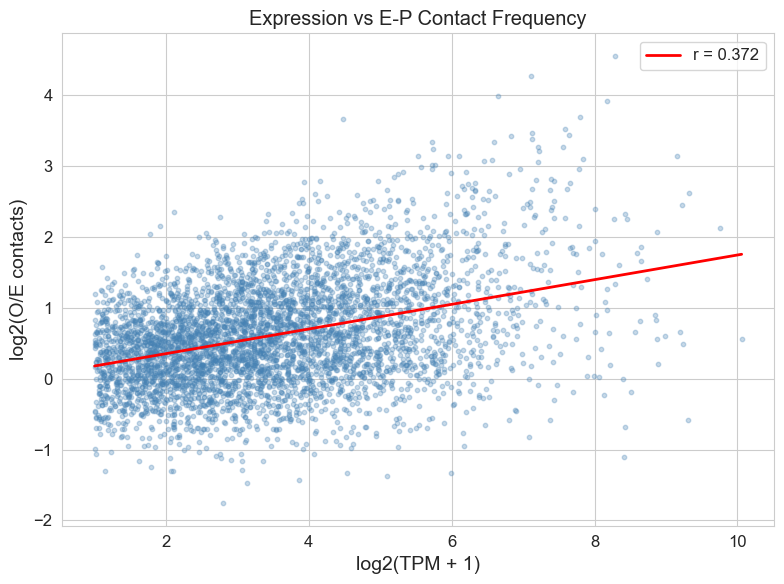

In [21]:
# Run all tests on synthetic data
print("="*60)
print("TEST 1: Overall Expression-Contact Correlation")
print("="*60)
results_overall = test_expression_contact_correlation(synthetic_ep)

TEST 2: Distance-Dependent Correlation


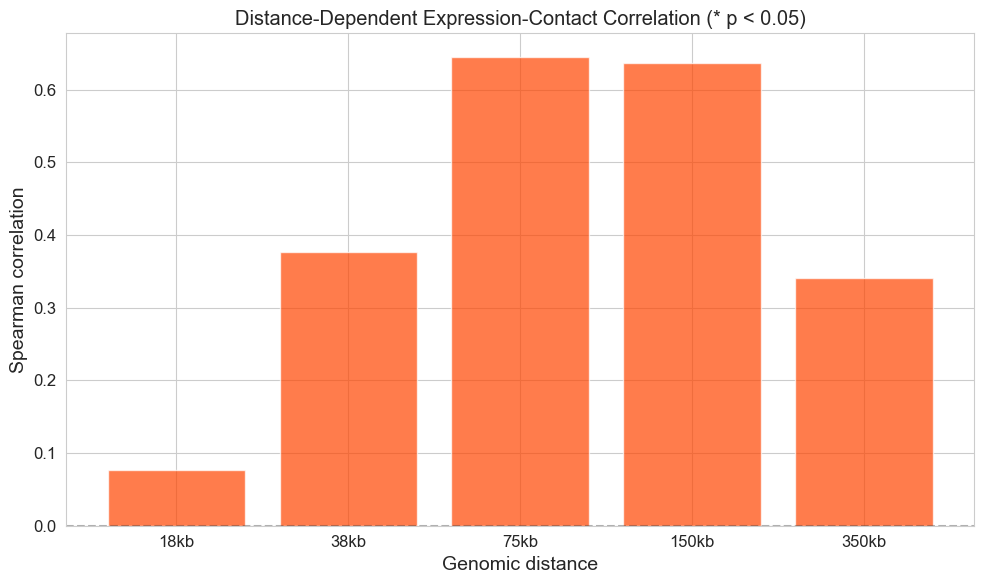

 distance_center_kb  correlation      p_value  n_pairs
               17.5     0.077240 9.582465e-03     1124
               37.5     0.377277 1.947571e-29      829
               75.0     0.645513 8.577069e-93      777
              150.0     0.636720 6.129353e-98      851
              350.0     0.341439 2.690110e-30     1058


In [22]:
print("="*60)
print("TEST 2: Distance-Dependent Correlation")
print("="*60)
results_distance = test_distance_dependent_correlation(synthetic_ep)

TEST 3: Super-Enhancer vs Typical Enhancer
Super-enhancer pairs: 1228, Typical enhancer pairs: 3413
Super-enhancer correlation: r = 0.389
Typical enhancer correlation: r = 0.308


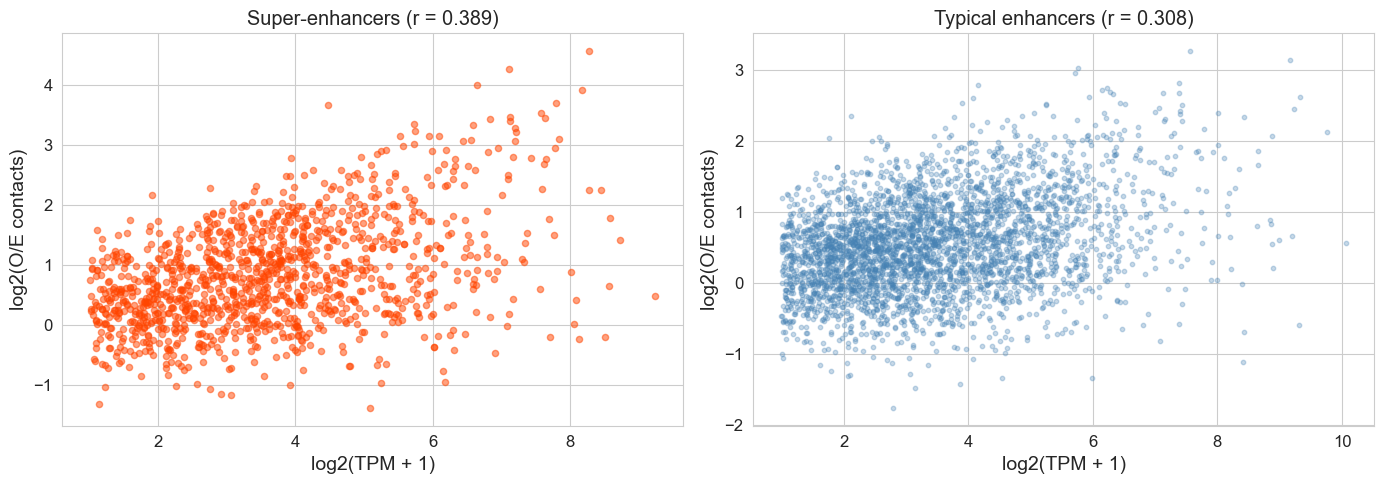

In [23]:
print("="*60)
print("TEST 3: Super-Enhancer vs Typical Enhancer")
print("="*60)
results_se = compare_super_vs_typical_enhancers(synthetic_ep)

---
## Part 7: Summary and Next Steps

### Expected Results (if Goh model is correct):
1. Positive correlation between expression and E-P contacts
2. Correlation peaks at intermediate distances (~50-150 kb)
3. Stronger correlation for super-enhancer-associated genes

### Caveats:
- Correlation does not prove causation
- Hi-C/Micro-C are population-averaged
- Strongest test would involve perturbation experiments

### Next Steps:
1. Download real mESC data
2. Re-run analysis with actual data
3. Compare quantitative effect sizes with model predictions
4. Control for confounders (gene length, GC content)